# Exploring Volume Vs. Price Reversal

#### Date: 08/03/2022
#### Author: Isaac Lee

## Question
Is there a pattern/correlation with changes in volume vs changes in (close) price?

In [235]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import my_data_pipelines as mdp

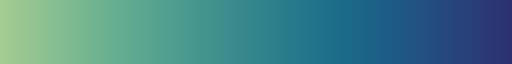

In [236]:
sns.set(rc={"figure.figsize":(25, 12)})
sns.set_context("poster")
palette = "crest"
sns.set_palette(palette=palette)
my_colors = ["#1e90ff", "#1D2562"]
sns.color_palette(palette=palette, as_cmap=True)

In [237]:
original_df = pd.read_csv("USDT_BTC_30mins_candles_2017-2022.csv")

In [238]:
print(original_df.shape)
original_df.head(3)

(87413, 7)


,date,weightedAverage,close,high,low,open,volume
0,2017-01-01T00:00:00.0,963.754077,966.149998,966.150000,961.700000,965.000001,11900.677348
1,2017-01-01T00:30:00.0,963.482304,964.133267,965.668127,962.879999,962.880000,2738.659872
2,2017-01-01T01:00:00.0,965.778383,965.855011,965.855012,964.133268,964.133268,1032.527297


## Aggregating into 4hr candles
Our original data is 30mins candles, so we aggregate to look at 4hrs.

In [239]:
# Get the number of rows, but since we are going to aggregate
# 30mins -> 4hr candles we need find the next smallest multiple of 8
n = (original_df.shape[0] // 8) * 8
print(f"Number of rows in our aggregated dataframe: {int(n / 8)}")

Number of rows in our aggregated dataframe: 10926


In [240]:
# This is a slow operation (there is probably a better implementation),
# so we will save to a csv and just load that after the first run.
using_csv = True

if using_csv:
    df = pd.read_csv("USDT_BTC_4hr_candles_2017-2022.csv")
else:
    df = pd.DataFrame()
    for i in range(0, n, 8):
        # Initialize our empty df to populate with values
        row_dict = {}

        # Take eight entry slices of our dataframe and aggregate values
        eight = original_df[i:i+8]
        # Note that we convert each entry to a list for compatability
        # with the pandas .from_dict() method
        row_dict['date'] = [eight.iloc[-1]['date']]
        row_dict['volume'] = [eight['volume'].sum()]
        row_dict['volatility'] = [eight['close'].std()]
        row_dict['weightedAverage'] = [eight['weightedAverage'].mean()]
        row_dict['close'] = [eight['close'].iloc[-1]]
        row_dict['open'] = [eight['open'].iloc[0]]
        row_dict['high'] = [max(eight['high'])]
        row_dict['low'] = [min(eight['low'])]

        # Append our current dataframe
        row_df = pd.DataFrame.from_dict(row_dict)
        df = pd.concat([df, row_df], ignore_index=True, axis=0)

    # Save result to csv
    df.to_csv("USDT_BTC_4hr_candles_2017-2022.csv", index=False)

In [241]:
print(f"Dataframe dimensions: {df.shape}")
df.head(2)

Dataframe dimensions: (10926, 8)


,date,volume,volatility,weightedAverage,close,open,high,low
0,2017-01-01T03:30:00.0,66617.446798,3.074947,963.597691,960.543195,965.000001,968.0000,957.020000
1,2017-01-01T07:30:00.0,59615.947687,1.910163,963.822140,967.800000,960.977614,967.9999,960.192267


Nice! So now we have our aggregated df, we just quickly check to see
how clean the data is.

In [242]:
df.isna().sum()

date               0
volume             0
volatility         0
weightedAverage    0
close              0
open               0
high               0
low                0
dtype: int64

For the last part of the data cleaning process we convert our
dateTime column to a datetime pandas Series:

In [243]:
df['date'] = pd.to_datetime(df['date'])

In [244]:
# Custom function to interactively scroll through the df
mdp.scroll_df(df)

interactive(children=(IntSlider(value=0, description='row_idx', max=10925), Dropdown(description='Sort by', in…

# EDA

## Volume Vs. Close

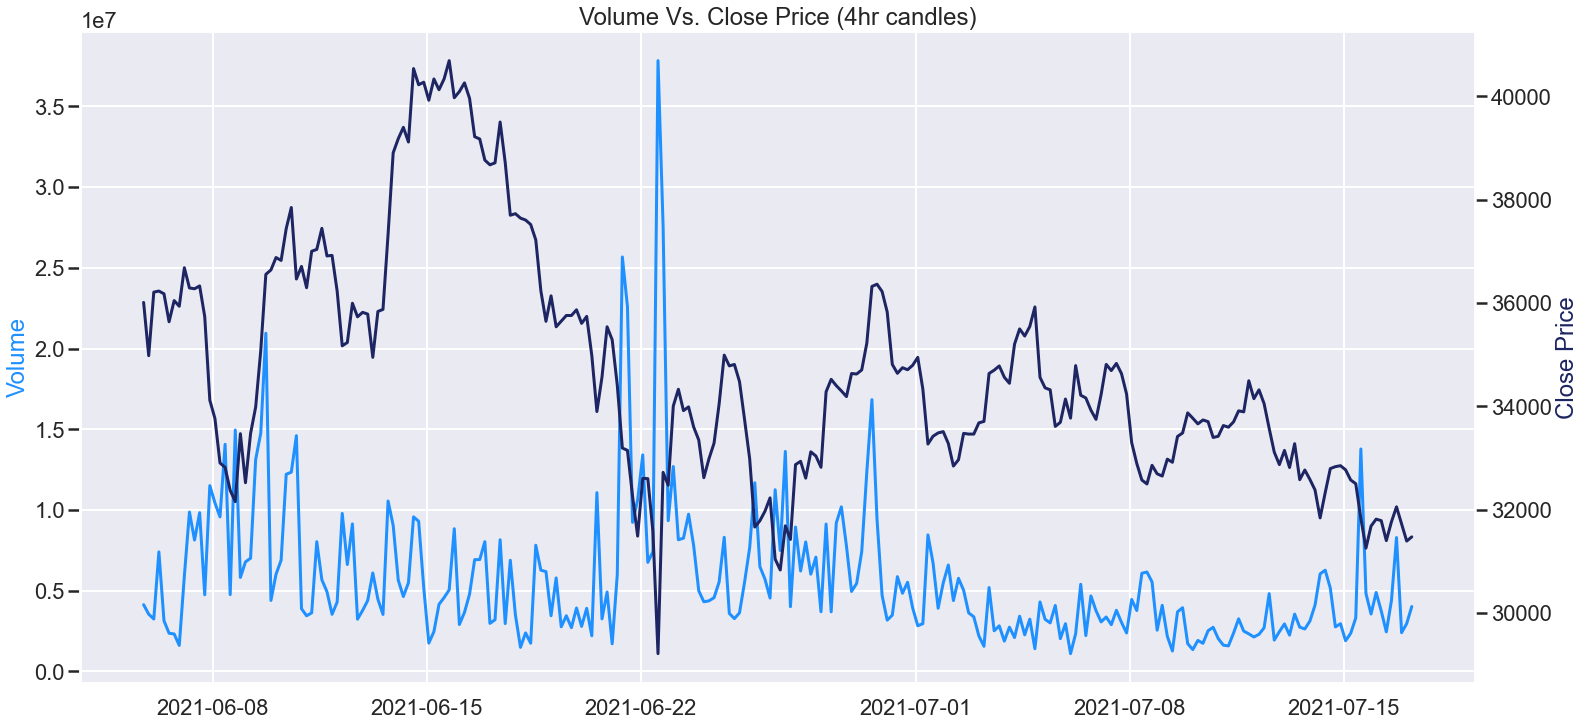

In [245]:
fig, ax1 = plt.subplots() # initializes figure and plots

num_candles = 250
offset = 1000
slice_df = df[-num_candles-offset:-offset]

ax2 = ax1.twinx()
sns.lineplot(data=slice_df, x='date', y='volume', ax=ax1, color=my_colors[0])
sns.lineplot(data=slice_df, x='date', y='close', ax=ax2, color=my_colors[1])

ax1.set_xlabel('')
ax1.set_ylabel('Volume', color=my_colors[0])
# ax1.set_xlim([df.dateTime.iloc[0], df.dateTime.iloc[-1]])
# ax2.set_xlim([df.dateTime.iloc[0], df.dateTime.iloc[-1]])
ax2.set_ylabel('Close Price', color=my_colors[1])
ax2.grid(False)
plt.title(f"Volume Vs. Close Price (4hr candles)")

# plt.savefig(f'USDT_BTC_volume_vs_close_last_{num_candles}_candles.png')
plt.show()

## Conjecture

Over some time interval to be determined, a change in volume (over a certain threshold $v$) $\implies$ (with high probability) that the close price will change over the next time interval.

To be more precise, let:  
$$
\begin{align}
 \delta_V(t) &:= \text{Percentage change in volume from time } t - \Delta t \text{ to } t  ~ ~ ~ ~ ~ ~ ~ ~  \text{ (for some } \Delta t). \\
 \delta_P(t) &:= \text{Percentage change in (close) price from time } t - \Delta t \text{ to } t ~ ~ ~ ~ ~ ~ ~ ~  \text{ (for some } \Delta t). \\
\end{align}
$$

We conjecture that:
$$
\begin{align}
\exist \Delta t, v \in \mathbb{R}^+_0 : P(\delta_P(t+\Delta t) \gt 0 ~ ~ | ~ ~ \delta_V(t) \gt v) \not\approx 0.5 \\
\end{align}
$$

Where $v$ and $\Delta t$ are constants to be chosen/determined.  

## Testing the conjecture
### Choosing $\Delta t$
We will start by choosing $\Delta t$ to be the length of 6, 4hr candles, i.e $\Delta t = 24hrs$.
We do this because it represents a nice time frame (a day) but also because the number of entries
in our dataframe is divisible by 6 so it's a nice number to work with.

In [246]:
del_t = 6

### Splitting the DataFrame into $\Delta t$ intervals

In [247]:
n = df.shape[0] # Total number of rows
delta_df = pd.DataFrame()
for i in range(0, n, del_t): # Bin rows into groups of 6
    row_dict = {}
    six = df[i:i+del_t]  # 6 row slice
    # Close price
    start_close = six['close'].iloc[0]
    end_close = six['close'].iloc[-1]
    # When calculating percentage changes, we need to account for
    # zero division errors
    if start_close < 1:
        row_dict['del_p'] = [1.0]  # 100% increase, from a 0 start price
    else:
        row_dict['del_p'] = [(end_close - start_close) / start_close]
    # Volume
    start_vol = six['volume'].iloc[0]
    end_vol = six['volume'].iloc[-1]
    # zero division errors
    if start_vol < 1:
        row_dict['del_v'] = [1.0]  # 100% increase, from a 0 start volume
    else:
        row_dict['del_v'] = [(end_vol - start_vol) / start_vol]
    # For time, recall del_v(t) := change in volume from time t - del_t to t,
    # so the time should be the time of the final candle in the slice
    row_dict['date'] = [six['date'].iloc[-1]]
    # Convert to a df and append
    row_df = pd.DataFrame.from_dict(row_dict)
    delta_df = pd.concat([delta_df, row_df], ignore_index=True, axis=0)



In [248]:
delta_df.head(3)

,del_p,del_v,date
0,0.040416,6.481959,2017-01-01 23:30:00
1,0.005923,1.284866,2017-01-02 23:30:00
2,0.008942,1.291023,2017-01-03 23:30:00


In [249]:
delta_df.describe()

,del_p,del_v
count,1821.000000,1821.000000
mean,0.003086,0.508092
std,0.038755,1.854694
min,-0.244779,-1.000000
25%,-0.013550,-0.360602
50%,0.002179,0.014613
75%,0.020495,0.721199
max,0.304327,36.795678


So it appears that on average, the volume increases 50%, which makes sense since more and more bitcoin has been traded over the last 5 years.
Also there is a positive average price change, which also makes sense because bitcoin has famously increased in price over the past 5 years.

Next we 'lag' or shift our price delta column, so that we can
compare $\delta_V(t)$ against $\delta_P(t + \Delta t)$:

In [250]:
delta_df['lag_del_p'] = delta_df['del_p'].shift(1)

### Distribution of $\delta_V$ and $\delta_P(t)$
We can use a kde (kernel density estimate) to get a sense of the distribution of the delta values:

Mean del_p: 0.003086081423947543
Variance del_p: 0.0015019456987249847


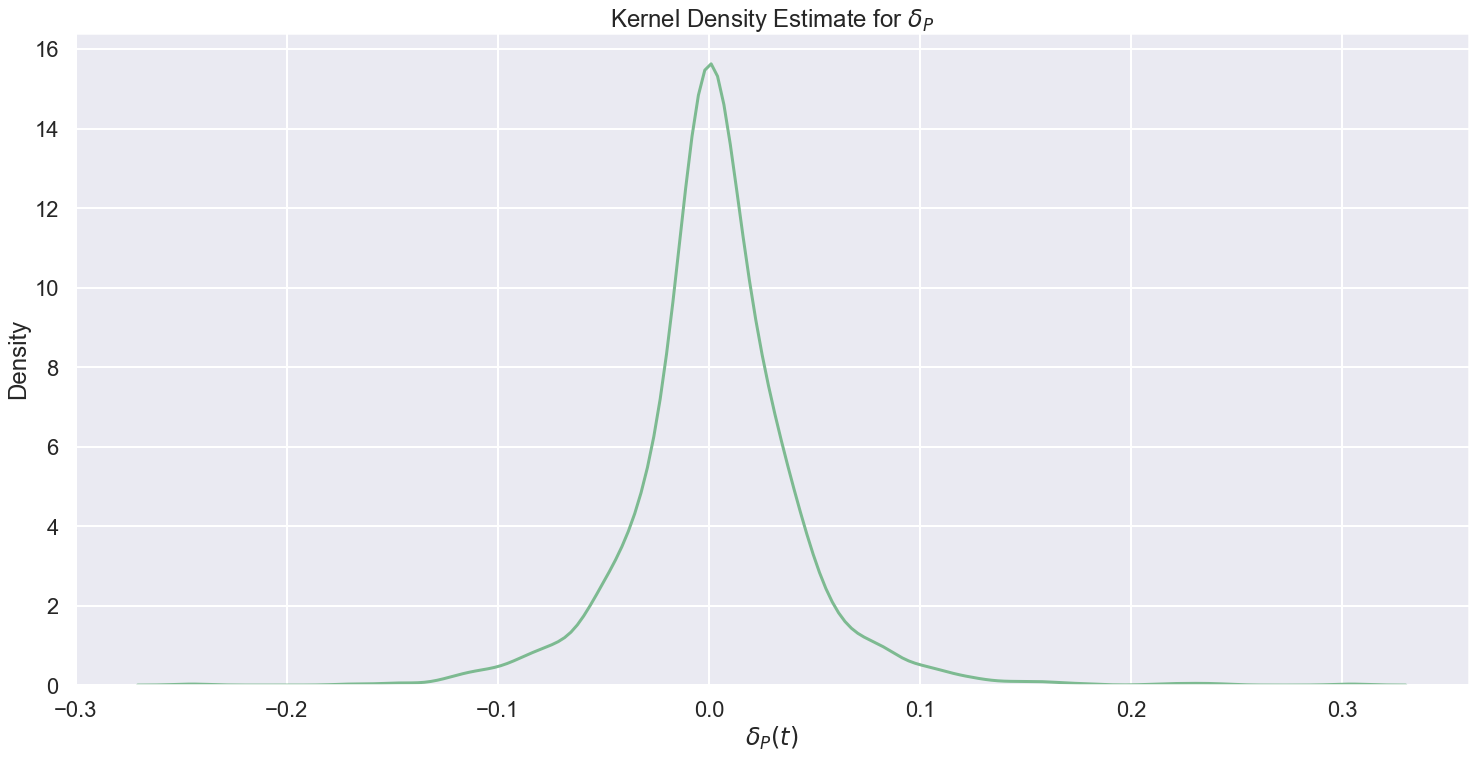

In [251]:
g = sns.kdeplot(delta_df["del_p"], color=my_colors[0])
plt.xlabel("$\delta_P(t)$")
plt.title("Kernel Density Estimate for $\delta_P$")
plt.savefig(f"USDT_BTC_price_change_distribution.png")
print(f"Mean del_p: {delta_df['del_p'].mean()}")
print(f"Variance del_p: {delta_df['del_p'].var()}")

So the evidence suggests that:
$$
\delta_P(t) \sim N(0.0031, 0.0015)  ~ ~ ~ ~ \forall t
$$
(Where $t \in (t_0, t_0 +\Delta t, t_0 + 2\Delta t, ..., t_0 + n\Delta t)$ for some starting time $t_0$.)

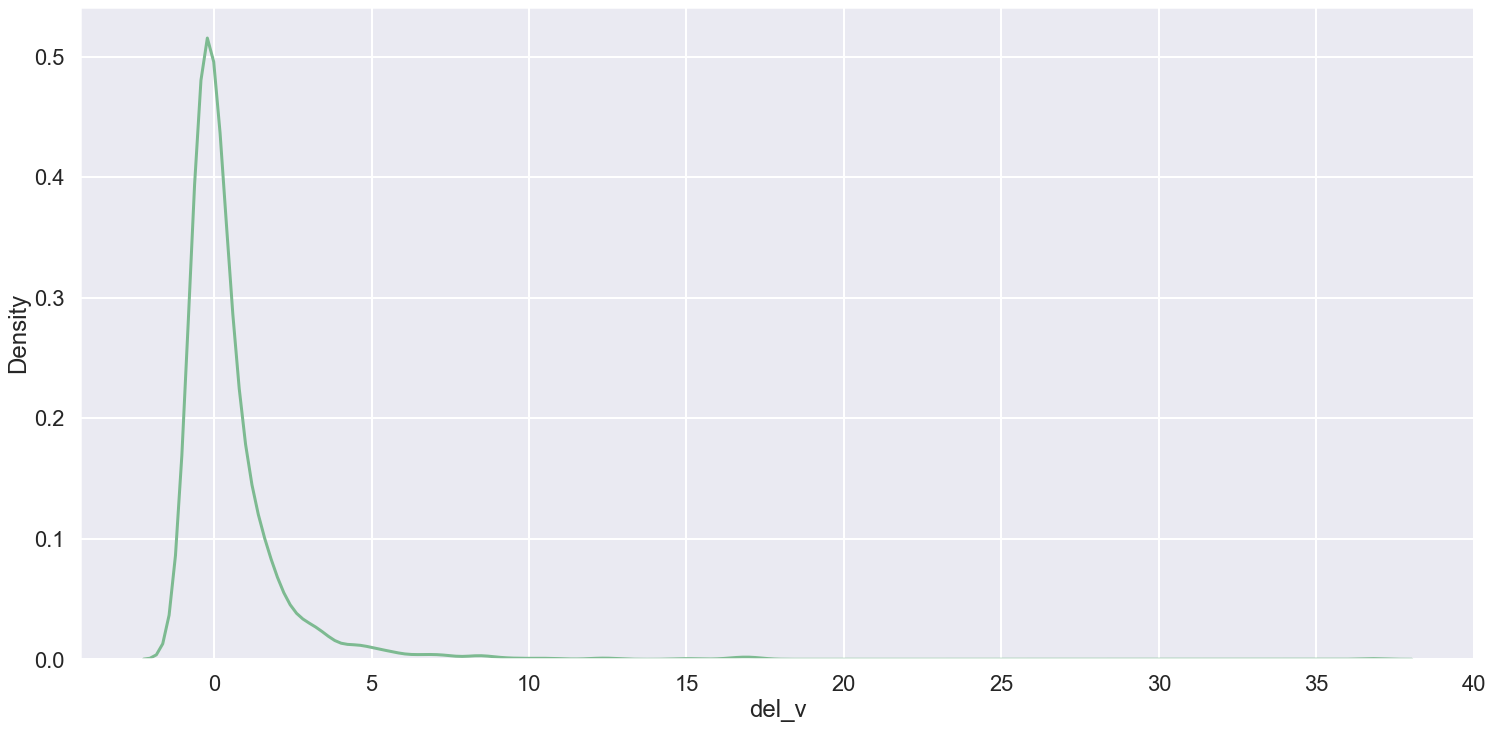

In [252]:
g = sns.kdeplot(delta_df['del_v'])

So because the volume often increases over 100%, our distribution is skewed.

### Checking Pearson Correlation

In [253]:
delta_df.corr()

,del_p,del_v,lag_del_p
del_p,1.000000,-0.040055,-0.105075
del_v,-0.040055,1.000000,0.009950
lag_del_p,-0.105075,0.009950,1.000000


### Determining $v$

In [254]:
import operator

def get_truth(inp, relate, cut):
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '==': operator.eq}
    return ops[relate](inp, cut)


def plot_p_v(op_p, op_v, v_max=10.0, v_step=0.5):
    X = np.arange(v_step, v_max, v_step)
    p = [delta_df[(get_truth(delta_df.del_v, op_v, v)) 
                & (get_truth(delta_df.lag_del_p, op_p, 0))].shape[0] 
        / delta_df[get_truth(delta_df.del_v, op_v, v)].shape[0] for v in X]
    count = [delta_df[get_truth(delta_df.del_v, op_v, v)].shape[0] for v in X]

    fig, ax1 = plt.subplots() # initializes figure and plots

    ax2 = ax1.twinx()
    sns.lineplot(x=X, y=p, ax=ax1, color=my_colors[0])
    ax1.set_xlabel('$v$')
    ax1.set_ylabel(f'$P(\delta_P(t+\Delta t) {op_p} 0 | \delta_V(t) {op_v} v)$', color=my_colors[0])

    sns.scatterplot(x=X, y=count, ax=ax2, color=my_colors[1])
    for x, y in zip(X, count):
        plt.text(x=x, y=y-25, s=y)
    ax2.set_ylabel(f"No. Occurances where $\delta_V(t) {op_v} v$", color=my_colors[1])
    ax2.grid(False)
    plt.title(f"$P(\delta_P(t+\Delta t) {op_p} 0 | \delta_V(t) {op_v} v)$ Vs. No. Occurances where $\delta_V(t) {op_v} v$")


    plt.savefig(f"USDT_BTC_probability_vs_occurance_for_different_v_plot_{op_p}_{op_v}.png")
    plt.show()

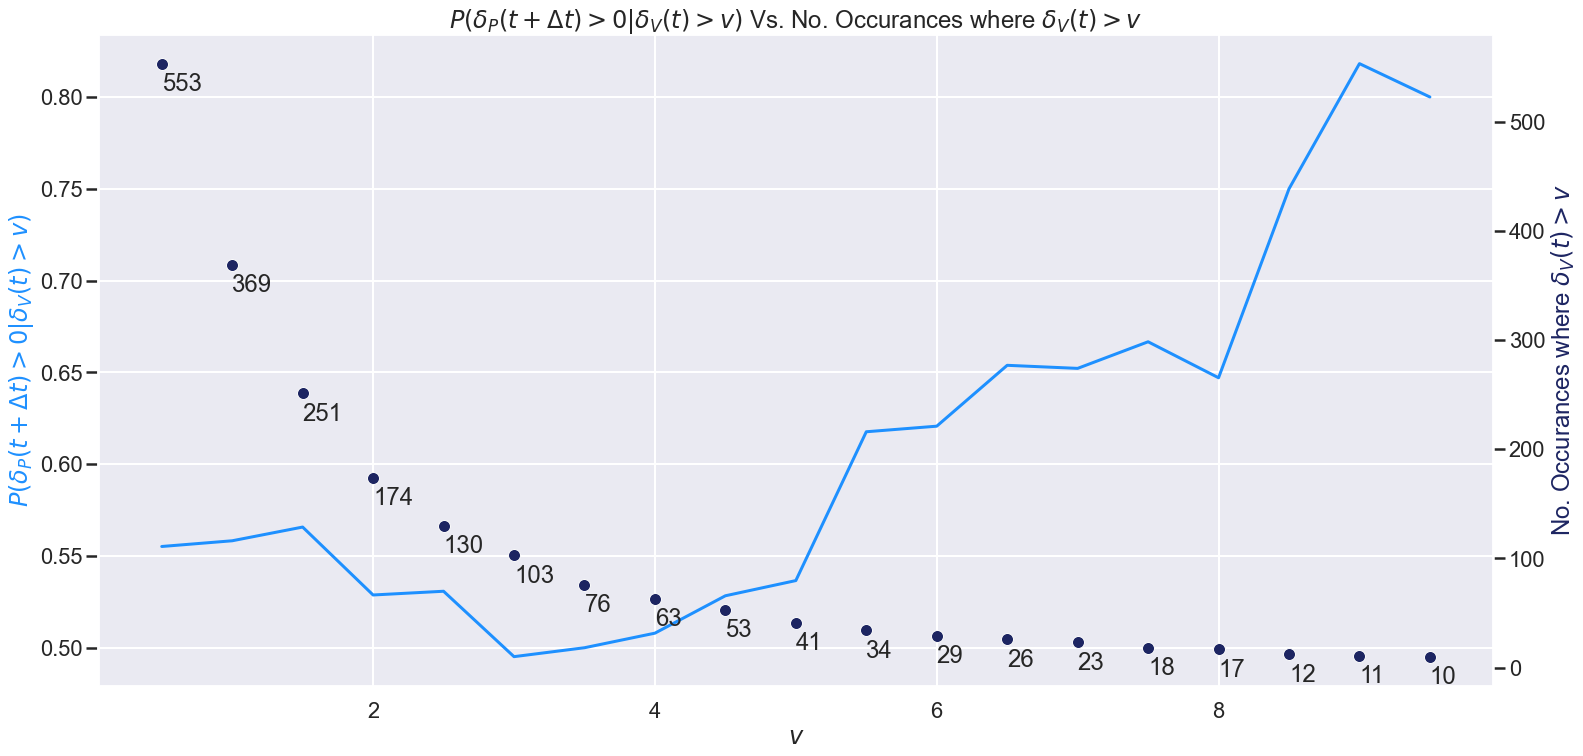

In [255]:
plot_p_v('>', '>')

This is a plot of the probability that the close price of the candle 6 (4hr) candles from
now will increase, given the (percentage) increase in volume is greater than $v$, against $v$.
We also plot the sample size or number of occurances where the percentage increase in $V$ is
greater than $v$.

From this plot we see that the probability that the price will
increase following an increase in volume over the threshold $v$,
increases as we increase $v$ and is significantly greater than 
50% for large enough $v$, which provides evidence to support
our conjecture. However we also see that as we increase $v$
that sample size decreases and this means our probabilities
become (perhaps) less representative of the true value, so it's
harder to make definite conclusions.

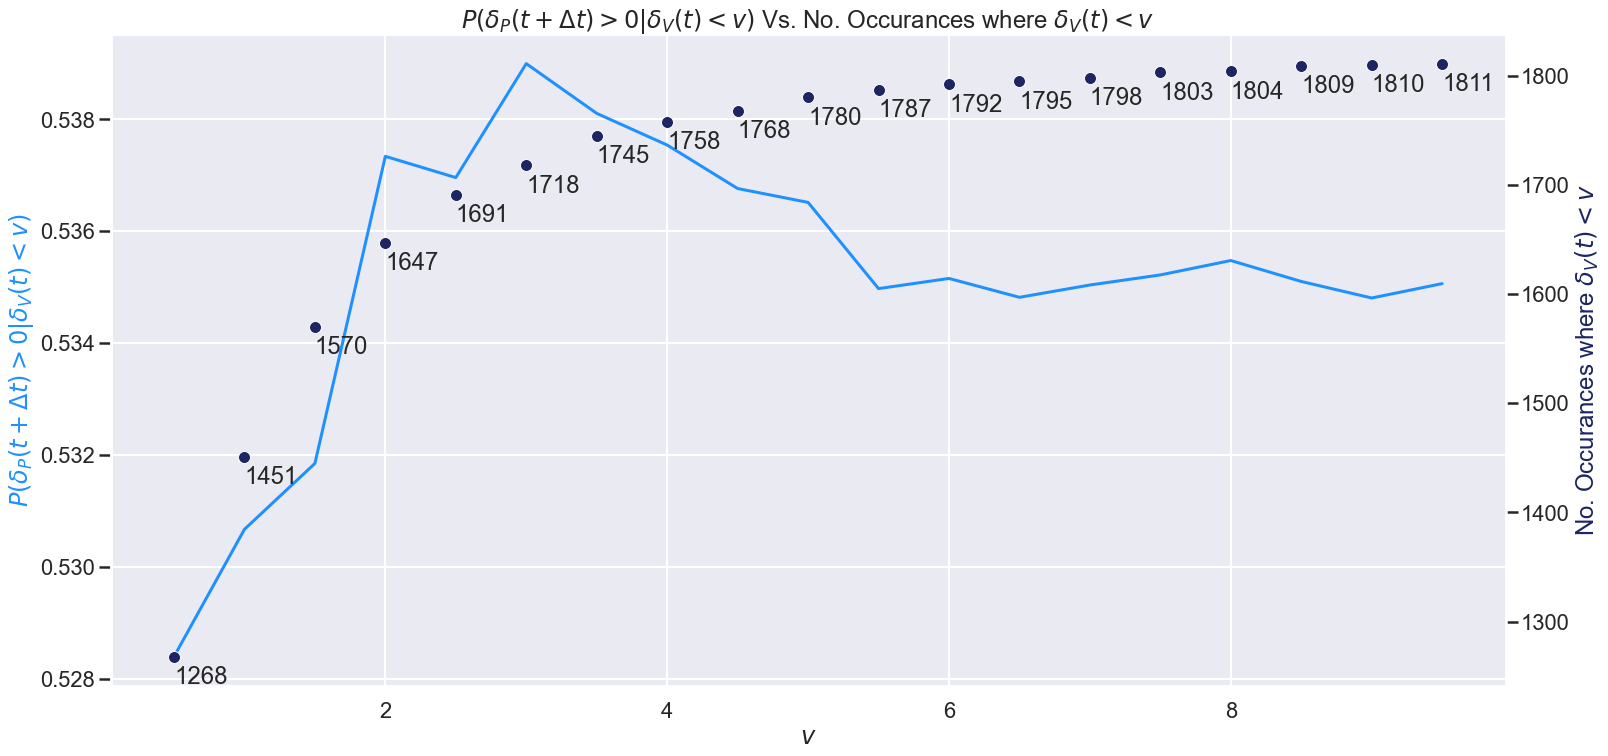

In [256]:
plot_p_v('>', '<')

So we see that the probability that the price will increase, following a *non-significant* volume
change (approximately) approaches 50%, which is what we would expect.

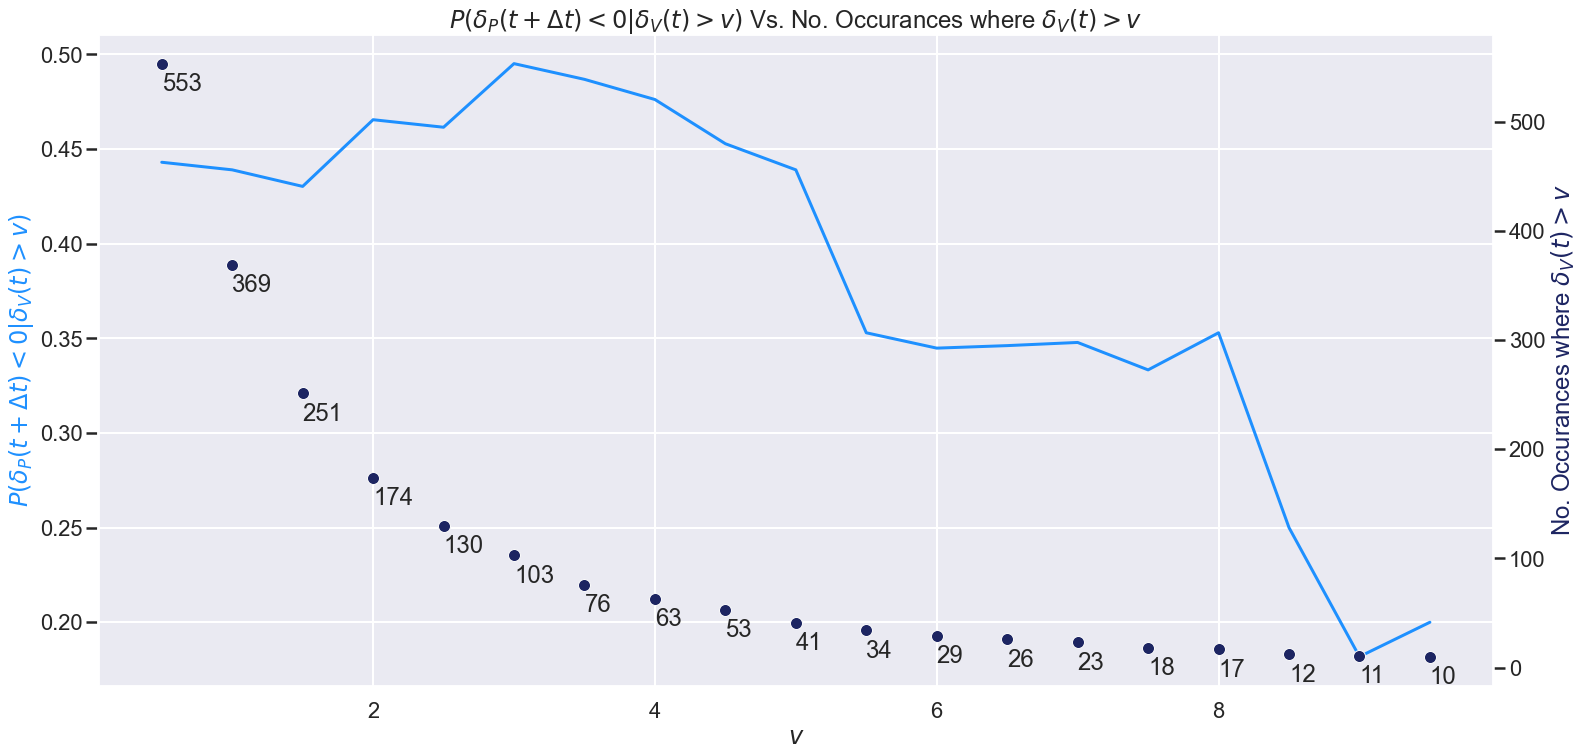

In [257]:
plot_p_v('<', '>')

(This is just the compliment of the first plot).

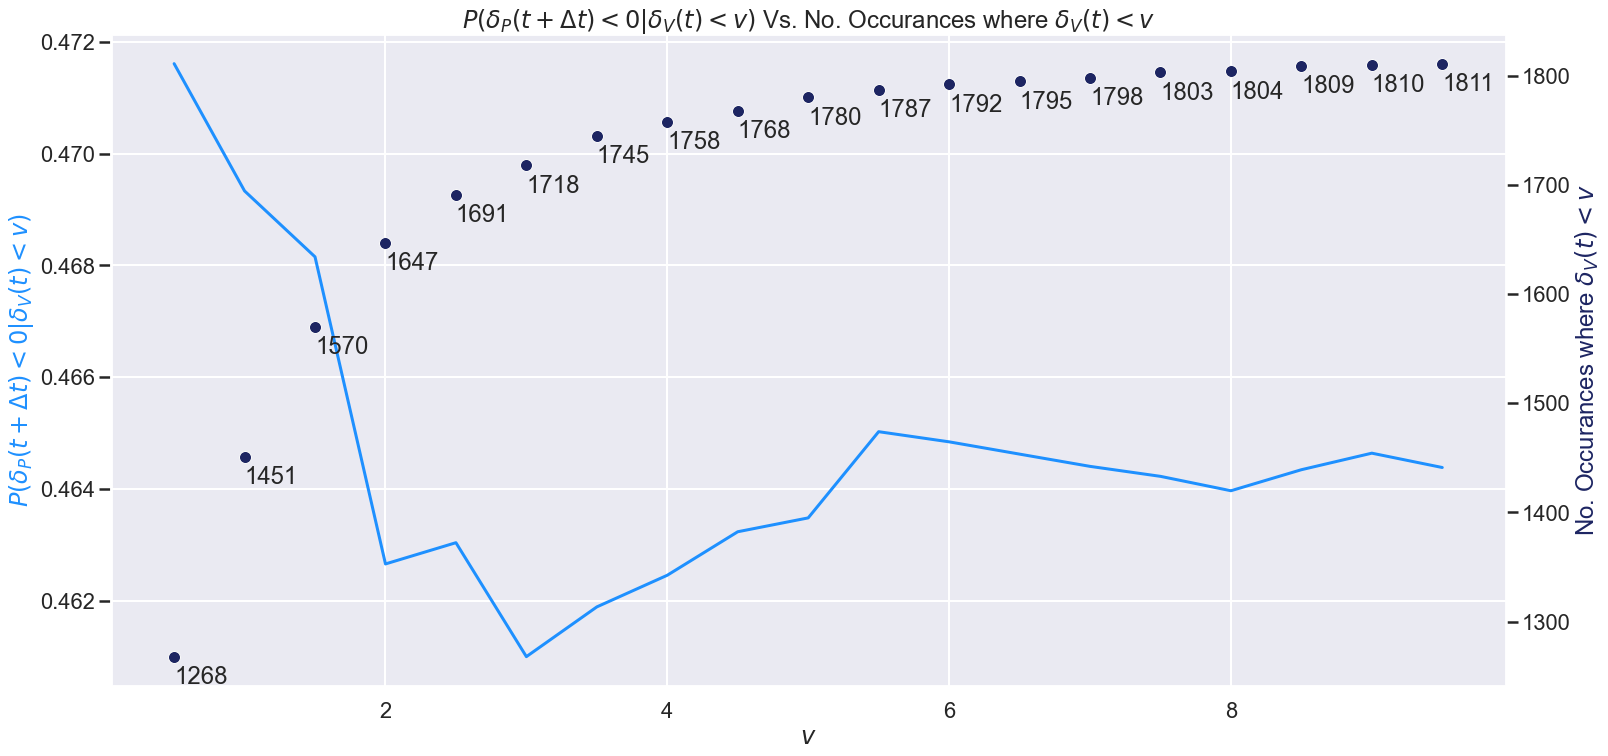

In [258]:
plot_p_v('<', '<')

(This is just the compliment of the second plot).